# Explaining model predictions with Shapley values

Shapley values provide an estimate of how much any particular feature influences the model decision. When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a *model-agnostic* measure of a feature's influence. This means that the influence of features may be compared across model types, and it allows *black box* models like neural networks to be explained, at least in part.

Here we will demonstrate Shapley values with logistic regression.

For more on Shapley values in general see Chris Molner's excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html

The `shap` package is installed if you have used the Titanic environment yasml file, but otherwise may be installed with `pip install shap`.

More information on the `shap` library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using `shap` with logistic regression. Logistic regression is the model type which least needs an *explainer* but it provides a useful example for learning about `shap` as Shapley values may be compared with model coefficients.

## Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Import shap for shapley values
import shap # `pip install shap` if neeed

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [4]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

# Drop PassengerId
X.drop('PassengerId',axis=1, inplace=True)

## Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

## Standardise data

Use SciKit learn method for standardising data.

In [6]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [7]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Fit logistic regression model

Now we will fir a logistic regression model, using sklearn's `LogisticRegression` method.

In [8]:
model = LogisticRegression(random_state=42)
model.fit(X_train_std,y_train)

LogisticRegression(random_state=42)

## Predict values and get probabilities of survival

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [9]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

# Predict probabilities of survival
y_prob_train = model.predict_proba(X_train_std)
y_prob_test = model.predict_proba(X_test_std)

## Calculate accuracy

In this example we will measure accuracy simply as the proportion of passengers where we make the correct prediction. In a later notebook we will look at other measures of accuracy which explore false positives and false negatives in more detail.

In [10]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.808
Accuracy of predicting test data = 0.798


## Examining the model coefficients (weights)

In [11]:
# Get model co_efficients
co_eff = model.coef_[0]

# Put in DataFrame and sort by effect size
co_eff_df = pd.DataFrame()
co_eff_df['feature'] = list(X) # Get feature names from X
co_eff_df['co_eff'] = co_eff
co_eff_df['abs_co_eff'] = np.abs(co_eff)
co_eff_df_sorted = \
    co_eff_df.sort_values(by='abs_co_eff', ascending=False, inplace=False)

In [12]:
co_eff_df_sorted.head()

,feature,co_eff,abs_co_eff
10,male,-1.285766,1.285766
0,Pclass,-0.599109,0.599109
1,Age,-0.443450,0.443450
9,CabinNumberImputed,-0.383161,0.383161
2,SibSp,-0.326892,0.326892


So are three most influential features are:

* *male* (being male reduces probability of survival)
* *Pclass* (lower class passengers, who have a higher class number, reduces probability of survival)
* *age* (being older reduces probability of survival)

## Get Shapley values

We use the `shap_values` method from the SHAP library to get Shapley values.
We use the `explainer` method from the SHAP library to get Shapley values along with other data. 

In [13]:
def calculate_shapley_values(model, X_values):
    """
    We use the `explainer(X)` method to get objects with shap values, base
    value*, and feature data. *The base value is “the value that would be 
    predicted if we did not know any features for the current output.” 
    In other words, it is the mean prediction, or mean(yhat).
    """
    
    # Train explainer on Training set
    explainer = shap.Explainer(model, X_values)
    
    # To get Shapley values alone:
    shap_values = explainer.shap_values(X_values)

    # Get Shapley values along with base, and features
    shap_values_extended = explainer(X_values)
    
    return (shap_values, shap_values_extended)

In [14]:
# Get list of features
features = list(X_train)

# Get Shapley values for training data
(shapley_values_train, shapley_values_train_extended) = \
    calculate_shapley_values(model, X_train_std)

# Calculate mean Shapley value for each feature
co_eff_df['mean_shapley_values'] = shapley_values_train.mean(axis=0)

# Calculate mean absolute Shapley value for each feature
# This will give us the average importance of each feature
co_eff_df['mean_abs_shapley_values'] = np.mean(
    np.abs(shapley_values_train),axis=0)

# Get Shapley values for test data
(shapley_values_test, shapley_values_test_extended) = \
    calculate_shapley_values(model, X_test_std)

Add Shapley values to coefficient table.

In [15]:
co_eff_df.sort_values(by='abs_co_eff', ascending=False).head()
co_eff_df.head(10)

,feature,co_eff,abs_co_eff,mean_shapley_values,mean_abs_shapley_values
0,Pclass,-0.599109,0.599109,-0.075577,0.553688
1,Age,-0.443450,0.443450,0.021086,0.321889
2,SibSp,-0.326892,0.326892,0.021006,0.215346
3,Parch,-0.120718,0.120718,0.008693,0.091400
4,Fare,0.201812,0.201812,0.017323,0.103516
5,AgeImputed,-0.209965,0.209965,-0.025102,0.152032
6,EmbarkedImputed,0.098489,0.098489,0.005397,0.005397
7,CabinLetterImputed,0.080356,0.080356,0.010992,0.072992
8,CabinNumber,0.121569,0.121569,-0.021160,0.092512
9,CabinNumberImputed,-0.383161,0.383161,-0.061586,0.349546


Get top 10 influenctial features by co-effieceints or Shapley

In [16]:
# Get top 10 features
co_eff_top_10 = \
    co_eff_df.sort_values(by='abs_co_eff', ascending=False).head(10)['feature']

shapley_top_10 = \
    co_eff_df.sort_values(
    by='mean_abs_shapley_values', ascending=False).head(10)['feature']

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['Coefficients'] = co_eff_top_10.values
top_10_features['Shapley'] = shapley_top_10.values

# Display
top_10_features

,Coefficients,Shapley
0,male,male
1,Pclass,Pclass
2,Age,CabinNumberImputed
3,CabinNumberImputed,Age
4,SibSp,SibSp
5,CabinLetter_C,AgeImputed
6,AgeImputed,CabinLetter_C
7,Fare,Embarked_S
8,CabinLetter_E,Fare
9,CabinLetter_T,CabinLetter_E


We can see a lot of overlap between the most import fatures as estimated by coefficients and those estimated using mean absolute Shapley values. But they are not identical.

Plot comparison of Shapley and mode coefficients:

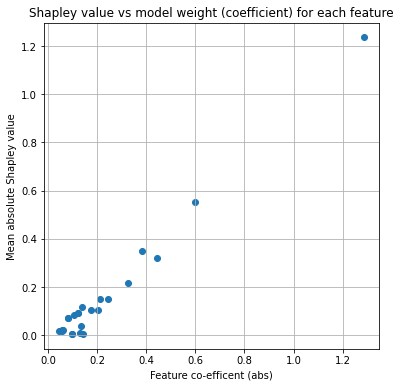

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Plot points
x = co_eff_df['abs_co_eff']
y = co_eff_df['mean_abs_shapley_values']
ax.scatter(x, y)
ax.set_title('Shapley value vs model weight (coefficient) for each feature')
ax.set_ylabel('Mean absolute Shapley value')
ax.set_xlabel('Feature co-efficent (abs)')
plt.grid()
plt.show()

## Plots of Shapley values

The `summary_plot` using a `plot_type` option of `bar` gives us the overall importance of each feature across the population.

Here we limit the num,ber of features shown to 15 (default is 20).

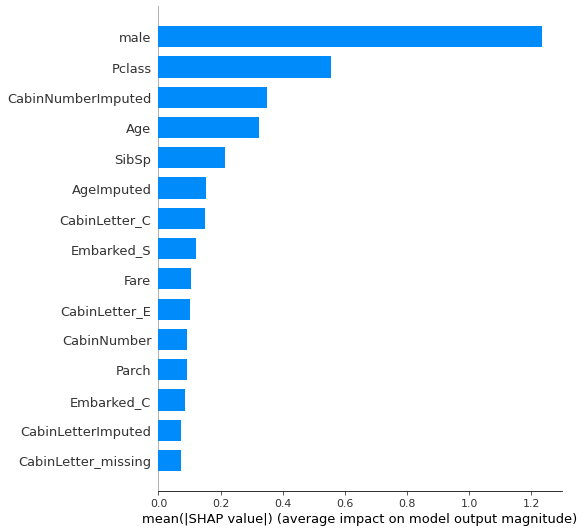

In [18]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train, 
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  plot_type='bar',
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

### Beeswarm plot

Without specifying a `plot_type` option of `bar`, `summary_plot` gives us a *beeswarm* plot, showing the Shapley values for all instances.

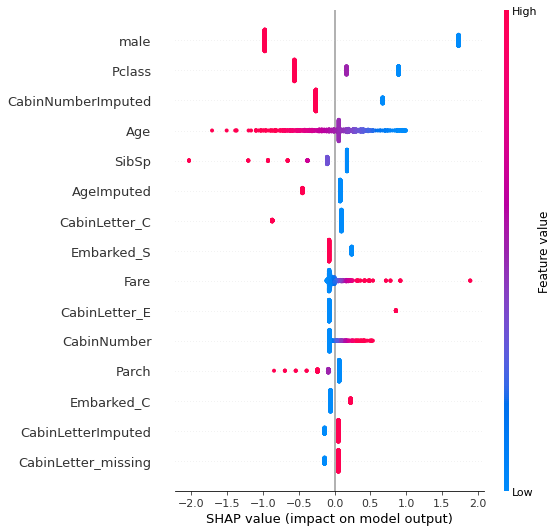

In [19]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train, 
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

## Waterfall plot

Waterfall plots show the influence of  individual features on model prediction. These are shown as the effect on *log odds ratio* of survival. *Log odds ratio* are usually shown as these are additive, whereas probabilities are not.

Waterfall plots put the most influential features at the top.

Waterfall plot for passenger with lowest probability of survival:

X has feature names, but LogisticRegression was fitted without feature names


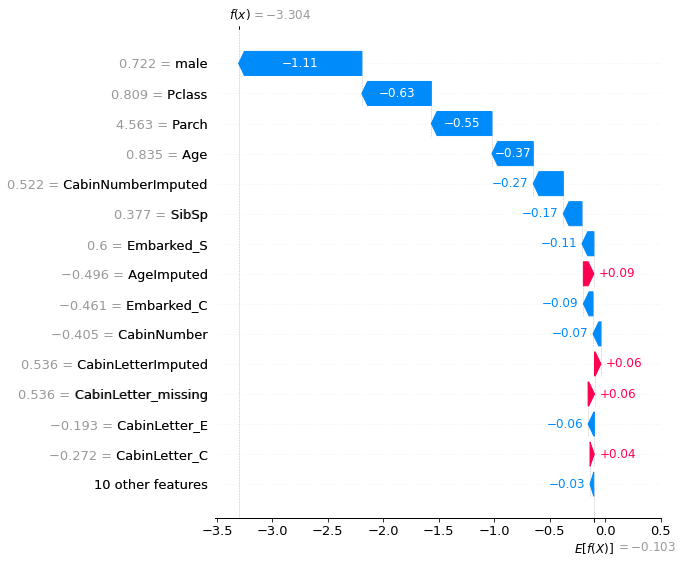

In [20]:
y_probs = model.predict_proba(X_test_std)

# For waterfall plot with feature names shap needs a df with feature names
df = pd.DataFrame(X_test_std, columns=list(X_train))

# Fit explainer model and get Shap values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)

# Get probability of survival
y_probs_survive = model.predict_proba(df)[:,1]
# Get index of lowest survival probability
location_low_probability = np.where(y_probs == y_probs_survive.min())[0][0]

# Waterfall plot
shap.plots.waterfall(shap_values[location_low_probability], max_display=15)

Waterfall plot for passenger with highest probability of survival:

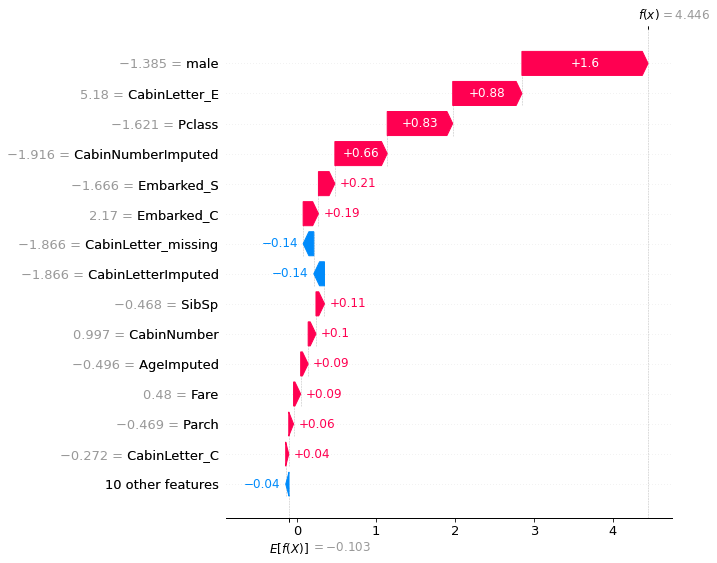

In [21]:
# Get index of lowest survival probability
location_high_probability = np.where(y_probs == y_probs_survive.max())[0][0]

# Waterfall plot
shap.plots.waterfall(shap_values[location_high_probability], max_display=15)

## Scatter plot

A scattter plot for one or more features shows the relationship between the feature value and the Shap value, along with a histogram of the frequency of the feature values.

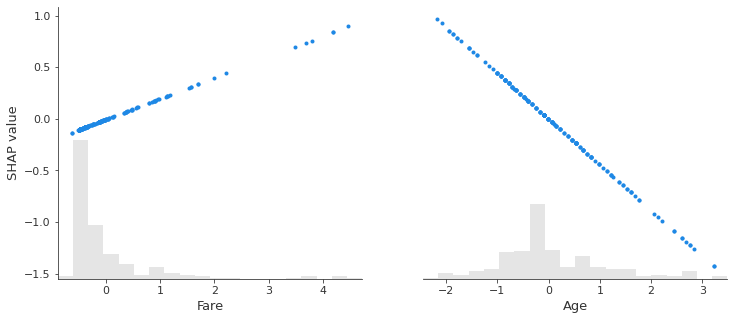

In [22]:
shap.plots.scatter(shap_values[:,['Fare', 'Age']])